In [36]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import statsmodels.api as sm
import statistics
from tqdm import tqdm

# Gasoline Data

Taken from *Rice, J.A.. Mathematical Statistics and Data Analysis (2006). International Thompson Publishing, Carlifornia, 3rd edition.*

When gasoline is pumped into the tank of an automobile, hydrocarbon vapors in the tank are forced out and into the atmosphere, producing a significant amount of air pollution. For this reason, vapor-recovery devices are often installed on gasoline pumps. It is difficult to test a recovery device in actual operation, because all that can be measured is the amount of vapor actually recovered and, by means of a "sniffer", whether any vapor escaped into the atmosphere. To estimate the efficiency of the device, it is thus necessary to estimate the total amount of vapor in the tank by using its relation to the values of variables that can actually be measured. In this exercise, you will try to develop such a predictive relationship using data that were obtained in a laboratory experiment. The file gasvapor contains recordings of the following variables: initial tank temperature (F) temperature of the dispensed gasoline (F), initial vapor pressure in the tank (psi), vapor pressure of the dispensed gasoline (psi), and emitted hydrocarbons (g). A prediction of emitted hydrocarbons is desired. <br>

We randomly select 40 observations and set them aside. The aim is to develop a predictive relationship based on the remaining observations and then test its strengthon the observations you have held out.

In [2]:
gas_train = pd.read_csv("./gasvapor_train.txt", quotechar="'")
gas_test = pd.read_csv("./gasvapor_test.txt", quotechar="'")

In [3]:
y_train = np.array(gas_train["Hydrocarbons"])
X_train = np.array(gas_train[["TankTemp", "GasTemp", "TankVapor", "GasVapor"]])
X_train = sm.add_constant(X_train)
y_test = np.array(gas_test["Hydrocarbons"])
X_test = np.array(gas_test[["TankTemp", "GasTemp", "TankVapor", "GasVapor"]])
X_test = sm.add_constant(X_test)

In [4]:
# utility
def rmspe(actual, predict):
    err = actual - predict
    return np.sqrt(np.sum(err**2)/len(err))

In [5]:
gas_train.head()

,TankTemp,GasTemp,TankVapor,GasVapor,Hydrocarbons
0,28,33,3.00,3.49,22
1,33,53,3.32,3.42,29
2,33,44,3.28,3.58,27
3,32,34,3.16,3.16,23
4,34,35,3.22,3.22,23


Characteristics: some of the covariates are correlated.

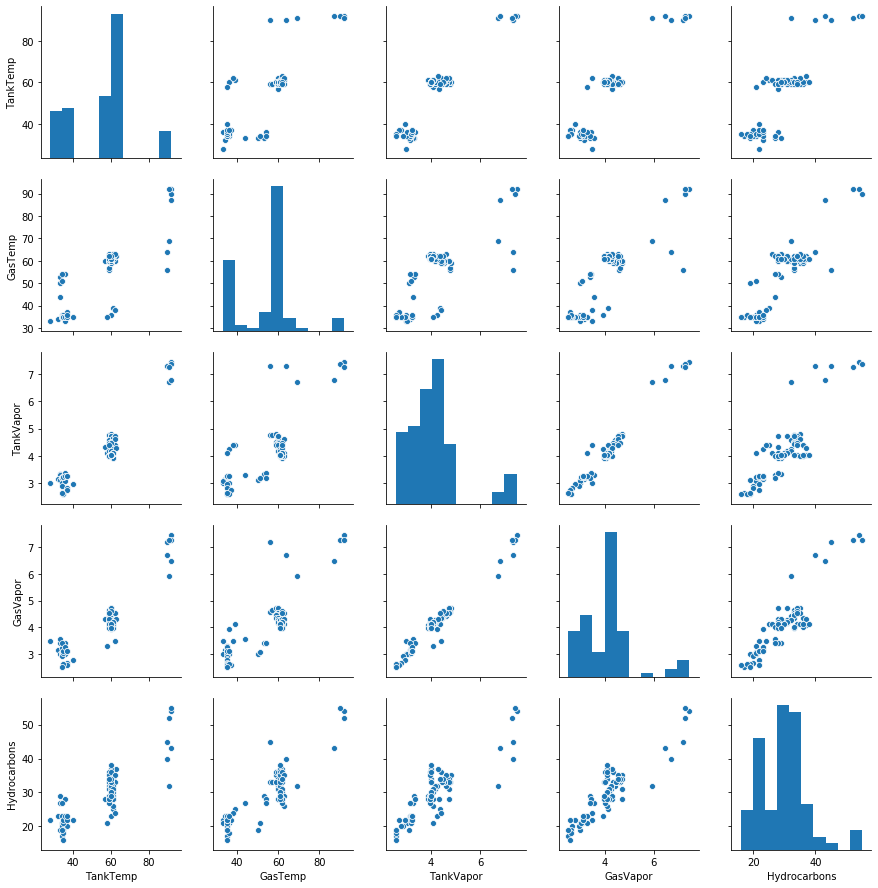

In [6]:
p = sns.pairplot(gas_train)

Linear Regression (OLS/MLE)

In [7]:
ols_model = sm.OLS(y_train, X_train)
ols_results = ols_model.fit()
ols_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     142.7
Date:                Mon, 25 Oct 2021   Prob (F-statistic):           1.39e-35
Time:                        17:22:50   Log-Likelihood:                -203.98
No. Observations:                  85   AIC:                             418.0
Df Residuals:                      80   BIC:                             430.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5676      1.301      0.436      0.664      -2.021       3.156
x1            -0.0264      0.065     -0.409      0.683      -0.155       0.102
x2             0.1848      0.052      3.542      0.001       0.081       0.289
x3            -2.4630      1.988     -1.239      0.219      -6.419       1.493
x4             7.4800      2.003      3.735      0.000       3.494      11.466
==============================================================================
Omnibus:                        0.317   Durbin-Watson:                   0.988
Prob(Omnibus):                  0.853   Jarque-Bera (JB):                0.088
Skew:                           0.070   Prob(JB):                        0.957
Kurtosis:                       3.072   Cond. No.                         748.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [8]:
ols_predict = ols_results.predict(X_test)
ols_rmpse = rmspe(y_test,ols_predict)
ols_rmpse

3.0018172073061287

Investigate principal components.

In [9]:
u, s, vh = np.linalg.svd(X_train)
np.allclose(X_train, u[:,:5] @ np.diag(s) @ vh)

True

We can then reduce into a generalised GSM

In [10]:
y_train_transformed = u[:,:5].T @ y_train
y_train_transformed

array([-280.54027378,    6.44443018,  -18.63374425,    1.06893781,
         -6.98888956])

Check that MLE gives OLS

In [17]:
alpha_times_theta = y_train_transformed
theta = np.array([(alpha_times_theta[i] / s[i]) for i in range(len(y_train_transformed))])
beta = vh.T @ theta
beta

array([ 0.56762404, -0.02643261,  0.18481497, -2.46300658,  7.47999043])

In [20]:
ols_results.params

array([ 0.56762404, -0.02643261,  0.18481497, -2.46300658,  7.47999043])

(1) James-Stein Estimator

In [42]:
def js(data):
    n = len(data)
    var = statistics.pstdev(data)
    return max(1 - (n-2)*var / np.sum(data**2), 0) * data

In [43]:
alpha_times_theta = js(y_train_transformed)
theta = np.array([(js(y_train_transformed)[i] / s[i]) for i in range(len(y_train_transformed))])
beta = vh.T @ theta
beta

array([ 0.56524153, -0.02632166,  0.18403924, -2.45266852,  7.44859443])

In [44]:
james_predict = X_test @ beta
james_rmspe = rmspe(y_test, james_predict)
james_rmspe

2.9898559102116686

(2) Hard thresholding

In [23]:
def hard_thresholding(data, thres):
    return np.array([((datum < -thres) or (datum > thres)) * datum for datum in data])

In [34]:
thresholds = np.arange(0.5,20.5,0.5)
hard_rmspe_array = []

for thres in thresholds:
    alpha_times_theta = hard_thresholding(y_train_transformed, thres)
    theta = np.array([alpha_times_theta[i] / s[i] for i in range(len(y_train_transformed))])
    beta = vh.T @ theta
    
    hard_predict = X_test @ beta
    hard_rmspe = rmspe(y_test, hard_predict)
    hard_rmspe_array += [hard_rmspe]

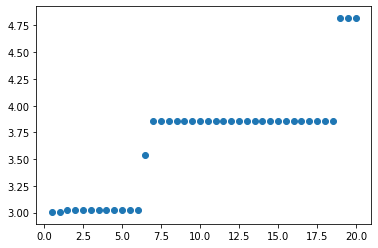

In [35]:
plt.scatter(np.arange(0.5,20.5,0.5), hard_rmspe_array)

No improvement since `y_train_transformed` is not sparse.